## 1. Introduction

The Muskingum-Cunge (MC) model is a kinematic wave approximation of the St. Venant equations with parameters based on channel characteristics. The model is coded in Fortran and frequently called by Python scripts in the t-route repository. This notebook demonstrates the application of the MC model. The notebook reviews how to create an extension module that allows Fortran functions to be called by Python, how to set up the model domain, specify river segment parameters, execute the model, and evaluate output. Model application is reviewed in the context of two simple experiments.

## 2. Add the Fortran routing directory to the system path

First, we need to add the single-segment Fortran routing directory to the system path. To use Fortran routing subroutines, we need to tell the system where they are located. We do this by adding new directories to the path.

In [1]:
import sys
sys.path.insert(1,'../src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS')

## 3. Compile and import Fortran extension module

Fortran code cannot be called by Python. Therefore, we need to generate a Python API file that contains wrappers for Fortran functions, so they can be called from Python. This is done using the `f2py3` - a Fortran to Python interface generator that creates an extension module that can be called by Python. This is done as a shell command:

```
$ f2py3 -c varPrecision.f90 MCsingleSegStime_f2py_NOLOOP.f90 -m mc_sseg_stime
```

Once the extension module is created, we can import it

**NOTE** - As of June 18, 2020 - this process is likely to become obsolete in the near future per contributions by RG. 

In [2]:
from mc_sseg_stime import muskingcunge_module

## 4. Import the `singlesegment` function
Next, we import `mc_sset_stime_NOLOOP_demo`, which contains a function called `singlesegment()` that calls the Fortran MC routing routine for a single timestep over a single river segment. 

In [3]:
import mc_sseg_stime_NOLOOP_demo as mc

# note - this throws a SyntaxWarning. Consider adjusting mc_sseg_stime_NOLOOP_demo.py accordingly 

## 5. Set up the model domain
Our simulation examples will consider wave movement through a single segment of a stream reach. A segment is the smallest elementary unit of a river network. Therefore, the spatial domain is simply defined by the segment length (meters). The time domain is defined by a timestep duration (seconds) and the number of timesteps to be simulated.  

In [4]:
# Time 
dt = 600 # timestep (seconds)
tsteps = 60 # number of timesteps

# Space 
dx = 2000.0 # segment length (meters)

## 6. Specify channel parameters
Channel parameters specify the geometric and hydraulic properties of the segment. The segment is assumed to have a compound cross section geometry with a trapezoidal channel and a rectangular floodplain. Channel and floodplain roughness are described by the Manning's roughness coefficient. The segment has a constant slope. 

In [5]:
# channel parameters
# cross section geometry
bw = 112.0 # Trapezoidal bottom width
tw = 448.0 # Channel top width (at bankfull)
twcc = 623.0 # Flood plain width
cs = 1.40 # channel trapezoidal sideslope

# Channel and floodplain roughness
n_manning = 0.028 # manning roughness of channel
n_manning_cc = 0.031 # manning roughness of floodplain

# Segment slope
s0 = 0.0018 # segment bed slope

## 7. Execute and analyze
### Experiment 1: State change from a lower flow condition to a higher one
Force the upstream boundary condition flow rate to be 2 times greater than the initial flow in the segment. Run the model until flow in the segment reaches steady state.  

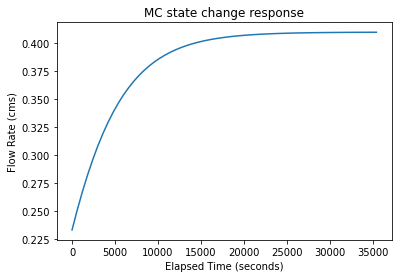

In [6]:
# lateral inflows
qlat = 0

# initial conditions
qup = 0.41 # Flow from the upstream neighbor in the previous timestep
quc = 0.41 # Flow from the upstream neighbor in the current timestep 
qdp = 0.21 # Flow at the current segment in the previous timestep
depthp = 0.010 # Depth at the current segment in the previous timestep #NOTE: I don't think the model does anything with this. 
velp = 0.070 # Velocity in the current segment in the previous timestep 

# initialize vectors to save results - flow and time
q_result = []
t_result = []

# step through time 
for k in range(0,tsteps):

    # run the MC routine for this timestep
    qdc, velc, depthc = mc.singlesegment(dt = dt
                                  , qup = qup
                                  , quc = quc
                                  , qdp = qdp
                                  , qlat = qlat
                                  , dx = dx
                                  , bw = bw
                                  , tw = tw
                                  , twcc = twcc
                                  , n_manning = n_manning
                                  , n_manning_cc = n_manning_cc
                                  , cs = cs
                                  , s0 = s0
                                  , velp = velp
                                  , depthp = depthp)
    
    # save simulation results for the kth timestep
    q_result.append(qdc)
    t_result.append(k*dt)
    
    # update initial conditions for next timestep
    qdp = qdc # Flow at the current segment in the previous timestep
    depthp = depthc # Depth at the current segment in the previous timestep')
    velp = velc # Velocity in the current segment in the previous timestep 

# Plot result
from matplotlib import pyplot as plt

plt.plot(t_result, q_result)
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Flow Rate (cms)')
plt.title('MC state change response')
plt.show()

The figure above shows the simulated change in flow rate at the downstream end of the 2 km river segment. As time proceeds, the flow rate at the segment outlet increases to match the flow rate at the upper boundary condition, which is twice the rate of the initial flow rate. Simulated flows reach a steady state after ~30000 seconds.

### Experiment 2: Propagating a pulse of water
Force the upstream boundary condition to be a rectangular shaped pulse. Observe how routing alters the shape of the upstream pulse at the downstream end of the river segment. 

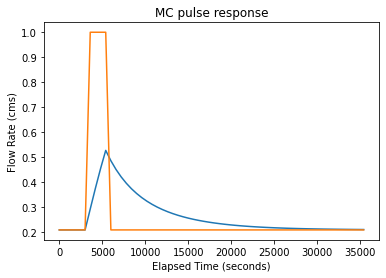

In [7]:
# lateral inflows
qlat = 0

# initial conditions - similar flow conditions in upstream seg and seg of interest
qup = 0.21 # Flow from the upstream neighbor in the previous timestep
quc = 0.21 # Flow from the upstream neighbor in the current timestep 
qdp = 0.21 # Flow at the current segment in the previous timestep
depthp = 0.010 # Depth at the current segment in the previous timestep
velp = 0.070 # Velocity in the current segment in the previous timestep 

# initialize 
qus = []
q_result = []
t_result = []

# step through time 
for k in range(0,tsteps):
    
    # Create a pulse upstream boundary by conditionally changing as a function of time
    if k <= 5:
        qup = 0.21
        quc = 0.21
    
    if 5 < k < 10:
        qup = 1
        quc = 1
        
    else: 
        qup = 0.21
        quc = 0.21
        

    # run the MC routine for this timestep
    qdc, velc, depthc = mc.singlesegment(dt = dt
                                  , qup = qup
                                  , quc = quc
                                  , qdp = qdp
                                  , qlat = qlat
                                  , dx = dx
                                  , bw = bw
                                  , tw = tw
                                  , twcc = twcc
                                  , n_manning = n_manning
                                  , n_manning_cc = n_manning_cc
                                  , cs = cs
                                  , s0 = s0
                                  , velp = velp
                                  , depthp = depthp)
    
    # save simulation results for the kth timestep
    q_result.append(qdc)
    t_result.append(k*dt)
    qus.append(quc)
    
    # update initial conditions for next timestep
    qdp = qdc # Flow at the current segment in the previous timestep
    depthp = depthc # Depth at the current segment in the previous timestep
    velp = velc # Velocity in the current segment in the previous timestep 
    
plt.plot(t_result, q_result)
plt.plot(t_result,qus)
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Flow Rate (cms)')
plt.title('MC pulse response')
plt.show()

In the plot above, the upstream boundary condition (flow at the upper end of the segment) is illustrated with an orange line. The simulated upstream pulse increases from 0.21 cms to 1 cms at t = 300 seconds, upstream flow remains at 1 cms until t = 600 seconds, after which the flow rate abruptly decreases back to 0.21 cms. The downstream response is illustrated with a blue line. Wave propagation significantly alters the shape of the downstream hydrograph. Specifically, there is a more gradual increase from the initial condition (0.21 cms) to the peak flow, which is much lower than 1 cms. After the peak flow, a gradual recession occurs and downstream flows return to their initial condition after ~30000 seconds. 